<a href="https://colab.research.google.com/github/tdisheng/Personal-Page/blob/master/Advanced%20Computer%20Vision/SuperRes/PyTorch_Super_Resoltion_8x_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Dec  1 10:39:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.38       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget -q https://www.dropbox.com/s/93krpoqzvroxdu2/img_align_celeba.zip
!unzip -q img_align_celeba.zip

In [ ]:
import os
from glob import glob
from PIL import Image, ImageFilter
import time

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam,SGD

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from torch.utils.data import Dataset
from torchvision.transforms import Compose, CenterCrop, ToTensor, Resize #Scale is deprecated
from torchvision import models

In [ ]:
## Params and hyperparams
data_dir = './img_align_celeba/'
BATCH_SIZE = 64
EPOCHS = 1
LEARNING_RATE = 0.001
NUM_EPOCHS = 2
save_model_dir = './'

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Data

In [ ]:
class SuperResolutionDataset(Dataset):
    def __init__(self, root, large_size=(176, 176), small_size=(44, 44), transforms=None, limit=None):
        self.paths = glob(os.path.join(root, '*'))
        self.transforms = transforms
        self.large_size = large_size
        self.small_size = small_size
        if limit:
            self.paths = self.paths[:limit]

    def make_pair(self, target):
        resize = Compose([
                          transforms.Resize(self.large_size[0]),
                          transforms.CenterCrop(self.large_size)
                          ])
        target = resize(target)
        img = target.resize(self.small_size, Image.BILINEAR)
        return img, target

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        target = Image.open(self.paths[idx]).convert('RGB')
        img, target = self.make_pair(target)

        if self.transforms:
            # Currently random transforms do not get applied in the same way to both images
            img = self.transforms(img)
            target = self.transforms(target)

        return img, target

In [ ]:
## Transforms
image_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                    #    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [ ]:
srdata = SuperResolutionDataset(data_dir, transforms=image_transforms, small_size=(22, 22), large_size=(176, 176))

In [ ]:
loader = DataLoader(srdata,batch_size=BATCH_SIZE,shuffle=True)

In [ ]:
batch = next(iter(loader))
print('LowRes:',batch[0].shape,'  HiRes:',batch[1].shape)

LowRes: torch.Size([64, 3, 22, 22])   HiRes: torch.Size([64, 3, 176, 176])


In [ ]:
batch[0].max(),batch[1].max(), type(batch[0]),batch[0].min(),batch[1].min()

(tensor(1.), tensor(1.), torch.Tensor, tensor(0.), tensor(0.))

In [ ]:
batch[1].shape

torch.Size([64, 3, 176, 176])

In [ ]:
def compare_dataset_pics(x,y, img_num):
    print(x.shape, y.shape)
    x = x.to('cpu')
    x = x[img_num]
    y = y.to('cpu')
    y = y[img_num]

    fig = plt.figure(figsize=(10,10))
    a=fig.add_subplot(1,2,1)
    imgplot = plt.imshow(x.permute(1, 2, 0))
    a=fig.add_subplot(1,2,2)
    imgplot = plt.imshow(y.permute(1, 2, 0))

torch.Size([64, 3, 22, 22]) torch.Size([64, 3, 176, 176])


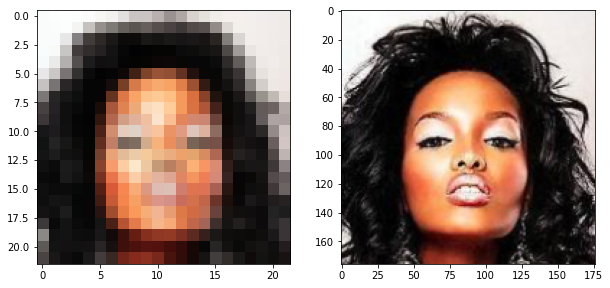

In [ ]:
compare_dataset_pics(batch[0],batch[1],img_num=0)

In [ ]:
print(len(srdata))
print(len(loader))

202599
3166


## Models

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=True):
        super(ConvBlock, self).__init__()
        self.activation = activation
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,stride=(1,1),padding=(1,1))
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        if self.activation == True:
            x = self.relu(x)
        return x
                            
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=True):
        super(ResBlock, self).__init__()
        self.conv_block_01 = ConvBlock(in_channels=in_channels,out_channels=out_channels, kernel_size=3, activation=True)
        self.conv_block_02 = ConvBlock(in_channels=in_channels,out_channels=out_channels, kernel_size=3, activation= False)
    
    def forward(self, x):
        identity = x
        x = self.conv_block_01(x)
        x = self.conv_block_02(x)
        x += identity
        return x

class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0):
        super(UpBlock, self).__init__()
        self.upsample = nn.Upsample(scale_factor=2)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x = self.upsample(x)
        x = self.conv(x)
        x = self.batchnorm(x)
        return F.relu(x)

In [ ]:
class TransformationNet(nn.Module):
    def __init__(self):
        super(TransformationNet,self).__init__()
        self.convblock1 = ConvBlock(3,64,3,activation=True)
        self.resblock1 = ResBlock(64,64,3)
        self.resblock2 = ResBlock(64,64,3)
        self.resblock3 = ResBlock(64,64,3)
        self.resblock4 = ResBlock(64,64,3)
        self.upblock = UpBlock(64,64,3,1)
        self.convblock2 = ConvBlock(64,64,3,activation=False)
        self.final_conv = nn.Conv2d(64,3,9,stride=(1,1),padding=4, padding_mode='reflect')
        self.bn = nn.BatchNorm2d(64)
        

    def forward(self,x):
        x = self.convblock1(x)
        x = self.resblock1(x)
        x = self.resblock2(x)
        x = self.resblock3(x)
        x = self.resblock4(x)
        x = self.upblock(x)
        x = self.upblock(x)
        x = self.upblock(x) # for 8x
        x = self.final_conv(x)
        x = torch.sigmoid(x)

        return x

In [ ]:
## VGG Perceptual Loss

vgg16 = models.vgg16(pretrained=True)
vgg_features = vgg16.features[:9].to(device)


# print(vgg16)
print(type(vgg_features))
vgg_features.eval()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



<class 'torch.nn.modules.container.Sequential'>


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
)

In [ ]:
img = torch.randn(1, 3, 176, 176).to(device)

In [ ]:
preds = vgg_features(img)

In [ ]:
## Assmeble the models
transform_model = TransformationNet().to(device)
transform_model.train()

TransformationNet(
  (convblock1): ConvBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (resblock1): ResBlock(
    (conv_block_01): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (conv_block_02): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
  )
  (resblock2): ResBlock(
    (conv_block_01): ConvBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [ ]:
img = torch.randn(1, 3, 22, 22).to(device)
preds = transform_model(img)
preds.shape

torch.Size([1, 3, 176, 176])

In [ ]:
criterion = nn.MSELoss()

In [ ]:
optimizer = optimizer = Adam(transform_model.parameters(), LEARNING_RATE)

In [ ]:

def compare_pics(low_res,preds,ground_truth, img_num):
    print(low_res.shape, preds.shape, ground_truth.shape)
    low_res = low_res.to('cpu').detach()#.numpy()[img_num]#.astype('uint8')
    ground_truth = ground_truth.to('cpu').detach()#.numpy()[img_num]#.astype('uint8')
    preds = preds.to('cpu').detach()
    low_res = low_res[img_num]
    preds = preds[img_num]
    ground_truth = ground_truth[img_num]
 
    fig = plt.figure(figsize=(13,13))
    a=fig.add_subplot(1,3,1)
    imgplot = plt.imshow(low_res.permute(1, 2, 0))
    a=fig.add_subplot(1,3,2)
    imgplot = plt.imshow(preds.permute(1, 2, 0))
    a=fig.add_subplot(1,3,3)
    imgplot = plt.imshow(ground_truth.permute(1, 2, 0))

## The training loop

Tue Dec  1 10:42:08 2020	Epoch 1:	[6400/202599]	loss: 0.004690
Tue Dec  1 10:43:15 2020	Epoch 1:	[12800/202599]	loss: 0.002284
Tue Dec  1 10:44:22 2020	Epoch 1:	[19200/202599]	loss: 0.001492
Tue Dec  1 10:45:29 2020	Epoch 1:	[25600/202599]	loss: 0.001134
Tue Dec  1 10:46:36 2020	Epoch 1:	[32000/202599]	loss: 0.000849
Tue Dec  1 10:47:43 2020	Epoch 1:	[38400/202599]	loss: 0.000724
Tue Dec  1 10:48:50 2020	Epoch 1:	[44800/202599]	loss: 0.000572
Tue Dec  1 10:49:57 2020	Epoch 1:	[51200/202599]	loss: 0.000510
Tue Dec  1 10:51:04 2020	Epoch 1:	[57600/202599]	loss: 0.000427
torch.Size([64, 3, 22, 22]) torch.Size([64, 3, 176, 176]) torch.Size([64, 3, 176, 176])
Tue Dec  1 10:52:11 2020	Epoch 1:	[64000/202599]	loss: 0.000385
Tue Dec  1 10:53:18 2020	Epoch 1:	[70400/202599]	loss: 0.000359
Tue Dec  1 10:54:25 2020	Epoch 1:	[76800/202599]	loss: 0.000335
Tue Dec  1 10:55:32 2020	Epoch 1:	[83200/202599]	loss: 0.000283
Tue Dec  1 10:56:39 2020	Epoch 1:	[89600/202599]	loss: 0.000273
Tue Dec  1 10:57:

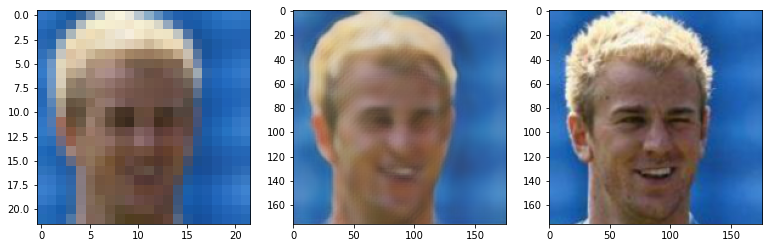

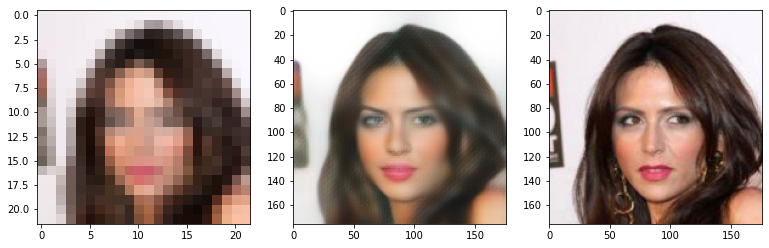

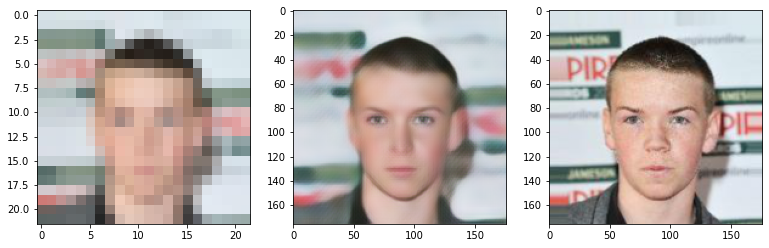

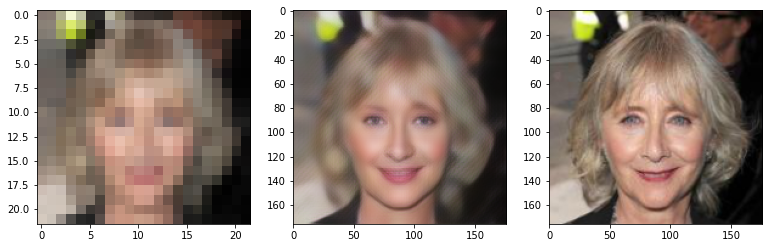

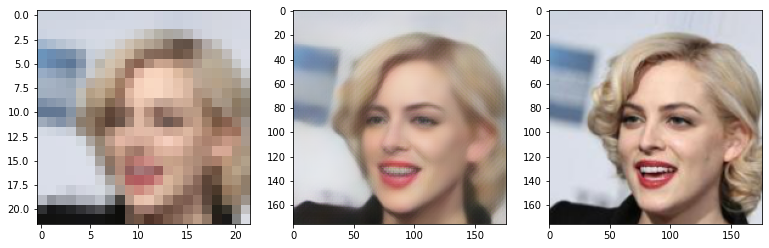

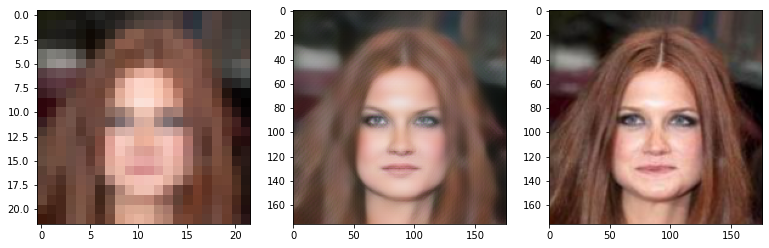

In [ ]:
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
        transform_model.train()
        epoch_loss = 0.
        count = 0
        for batch_id, (low_res_imgs, hi_res_imgs) in enumerate(loader):
            n_batch = len(low_res_imgs)
            count += n_batch
            
            optimizer.zero_grad()

            low_res_imgs = low_res_imgs.to(device)
            hi_res_imgs  = hi_res_imgs.to(device)
            
            preds = transform_model(low_res_imgs)

            # y = utils.normalize_batch(y)
            # x = utils.normalize_batch(x)

            features_preds = vgg_features(preds)
            features_hi_res = vgg_features(hi_res_imgs)

            # get the loss
            batch_loss = criterion(features_preds, features_hi_res)

            batch_loss.backward()
            optimizer.step()

            epoch_loss = batch_loss.item()


            if (batch_id + 1) % 100 == 0:
                if (batch_id + 1) % 1000 == 0:
                    # transform_model.eval()
                    compare_pics(low_res_imgs, preds,hi_res_imgs, img_num=5)
                mesg = "{}\tEpoch {}:\t[{}/{}]\tloss: {:.6f}".format(
                    time.ctime(), epoch + 1, count, len(srdata),
                                  epoch_loss / (batch_id + 1)

                )
                print(mesg)
            # if count>250:
            #     break


# # save model
save_model_dir
transform_model.eval().cpu()
save_model_filename = "epoch_" + str(epoch) + "_" + str(time.ctime()).replace(' ', '_') + "_" + ".model"
save_model_path = os.path.join(save_model_dir, save_model_filename)
torch.save(transform_model.state_dict(), save_model_path)

print("\nDone, trained model saved at", save_model_path)